# Bayes PRF: general fitting (not microprobing)

In [1]:
# # NOTE -> not too sure about how I'm calculating the log likelihood (this is quite important!!!)
# # Here is what I do (see ln_likelihood inside prf_bayes.py and micro_probe.py)

# # Below copied and pasted from inside prf_bayes.py
# # NOTE THIS WON'T work here - because it is not inside the correct class, this is just so you have 
# # a quick reference 
# from scipy import stats
# def ln_likelihood(self, params, response):
#     ''' THIS IS DODGY - ASK REMCO
#     Vaguely following:
#     https://github.com/Joana-Carvalho/Micro-Probing/blob/master/computing_mcmc_tiny_ica.m
    
#     '''
#     # [1] Get the predicted time series
#     model_response = self.prfpy_model_wrapper(params)        
    
#     # [2] Calculate the residuals
#     residuals = response - model_response

#     # [3] Fit a normal distribution to the residuals
#     muhat, sigmahat = stats.norm.fit(residuals)

#     # [4] Check if the spread is valid
#     if sigmahat <= 0:
#         return -np.inf

#     # [5] Calculate the log likelihood of the residuals
#     # given the fitted normal distribution (feels a bit circular?)
#     # then add it up for all time points
#     log_like = stats.norm.logpdf(residuals, muhat, sigmahat).sum()
#     return log_like

Before running this notebook - install this package
(i.e., in the terminal, inside this folder run:
"pip install -e .")

You also need: 

* emcee               https://emcee.readthedocs.io/en/stable/user/install/

* prfpy               https://github.com/VU-Cog-Sci/prfpy.git (or https://github.com/spinoza-centre/prfpy_csenf.git if you want the contrast sensitivity function.)

* dag_prf_utils       https://github.com/mdaghlian/dag_prf_utils.git


Also a bit of an apology... There is some inconsistency in naming between prfpy and dag_prf_utils. I promise there is a good reason for this. I want prfpy to be backwards compatible. But, some names interfere with each other, when you start including other models (e.g., size, compared to size_1, and size_2 in the DN model). Here is the mapping for the gaussian model:

```
prfpy       dag_prf_utils

mu_x        x
mu_y        y
size        size_1
beta        amp_1
baseline    bold_baseline
hrf_1       hrf_deriv
hrf_2       hrf_disp


```

Most of the time you shouldn't have to think about it...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


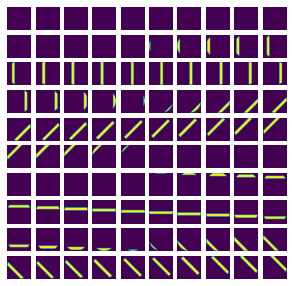

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, Norm_Iso2DGaussianModel
import os
import yaml
import pickle
from datetime import datetime

# If you already have the design matrix as a numpy array, you can simply load it...
dm = np.load('./design_matrix.npy')

# You can see we have a binarized matrix, of a bar moving across the screen...
fig = plt.figure()
rows = 10
cols = 10
fig.set_size_inches(5,5)
for i in range(100):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(dm[:,:,i], vmin=0, vmax=1)
    ax.axis('off')
# Now we need to enter the design matrix in a way that prfpy can read it. 
prf_stim = PRFStimulus2D(
    screen_size_cm=39.3,          # Distance of screen to eye
    screen_distance_cm=196,  # height of the screen (i.e., the diameter of the stimulated region)
    design_matrix=dm,                                   # dm (npix x npix x time_points)
    TR=1.5,                                  # TR
    )
# Now we can make the model
model = 'gauss'
g_model = Iso2DGaussianModel(stimulus=prf_stim, hrf=[1, 4.6, 0])
dn_model = Norm_Iso2DGaussianModel(stimulus=prf_stim, hrf=[1, 4.6, 0])

# If for some reason you do not have the original dimensions, but you do have the dov, you can use this calculator:
# https://elvers.us/perception/visualAngle/ to make up some values for screen_size and distance, which will work...
# Load the runs

psc_runs = np.load('eg_data.npy')

# Stretch move - an emcee MCMC fitting method

See:
https://msp.org/camcos/2010/5-1/camcos-v5-n1-p04-s.pdf
https://arxiv.org/pdf/1202.3665



### My dodgy explanation...


#### The traditional MCMC (metropolis hastings) method works something like this
```latex
1. Initialise
> start with some parameters: "a_current"
2. Proposal 
> Make some "step" in parameter space (probably based on a gaussian function)
> "a_proposed"
3. Evaluate
> plug in the parameters in a_current, and a_proposal to some function
> which gives the log likelihood (related to some goodness of fit measure)
4. Accept or reject
> Accept the new position with some probability
> the better the new position compared to the old, the more likely we are to accept. 
5. Repeat 
> for some number of steps
> storing all of the accepted positions


Note you can do this for multiple initial positions
You then remove the first few steps to avoid spurious correlations (burn in)
```


#### The "stretch move" works something like this


```latex
1. Initialise (the ensemble, made up of several walkers)
> not just 1 starting position, but several: "a_current", "b_current", etc.
2. Proposal
> Randomly one of the ensemble e.g., "a_current" to update
> Randomly select another ensemble member (e.g., "d_current") 
> Draw a line in parameter space from "a_current" to "d_current", then stretch along this line by some factor
> (the factor is randomly selected)
> compute the new position "a_proposal"
3. Evaluate: Same as in metropolis hastings
> get log likelihood
4. Accept or reject: same as metropolis hastings
5. Repeat 
> for some number of steps
> storing all of the accepted positions
```

The stretch move is useful because we don't have to think about the proposal function. Just start with a reasonable starting position, add some jitter so that not everything in the ensemble is the same, then let it run!!


The point is that the ensemble will only "stretch" along the "useful" trajectories in parameter (where a high probability is returned). This should be useful if we don't know what to expect from the covariance structure in parameter space 

# Example 1. HRF and gaussian model
Can we capture dependence between HRF and size in gaussian model

In [3]:
from prfpy_bayes.prf_bayes import BayesPRF
# Start by making the bprf objects
Gbprf = BayesPRF(
    prf_params=None, # We could put in our best guess here, but we will let the model figure it out...
    model = 'gauss',
    prfpy_model=g_model,
    real_ts=psc_runs,
    )
bounds = {
    'x': [-5, 5],
    'y': [-5, 5],
    'size_1': [0.1, 10],
    'amp_1': [0, 100],
    'bold_baseline': [0, 0],
    'hrf_deriv' : [0, 10],
    'hrf_disp' : [0, 10],
}
# Uniform prior, based on bounds 
Gbprf.add_priors_from_bounds(bounds)
# Get everything ready...
Gbprf.prep_info()

# Let start with a single voxel
initial_guess = [
    0, # x
    0, # y
    1, # size
    1, # amplitude
    4.6, # hrf_disp
    0, # hrf_deriv
]
# which timeseries to fit
idx = 0
Gbprf.run_mcmc_fit(
    initial_guess=initial_guess,
    idx=idx, 
    n_walkers=20,
    n_steps=500, 

)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
prf_params.shape[-1]=8
include hrf = True
include rsq = True
Running in serial


/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/daghlian/.conda/envs/dag_mcmc

prf_params.shape[-1]=8
include hrf = True
include rsq = True


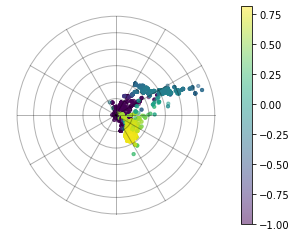

In [4]:
# Lets plot our samples around the visual field 
Gbprf.sampler[idx].visual_field(
    dot_col='rsq',      # Color by r squared
    th={},              # No threshold
    do_colbar=True,
    dot_vmin=-1,       
    dot_size=10,
)

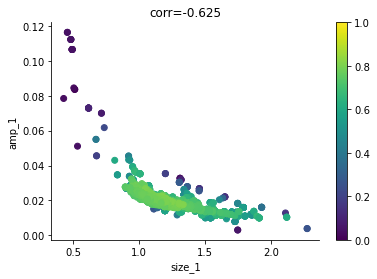

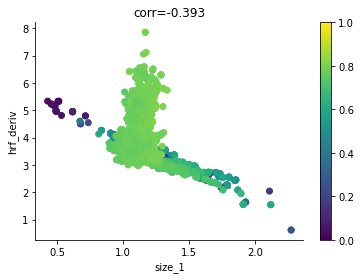

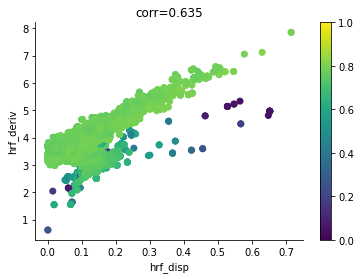

In [5]:
# Can we use this to look at some of the correlation structure in the parameters?
# -> i.e. which parameters can trade off against each other?
burn_in = 50

# For example size and amplitude
Gbprf.sampler[idx].scatter(
    px='size_1', py='amp_1',pc='rsq',
    vmin=0,vmax=1, 
    th={
        'min-step_id' : burn_in, # Only include samples after burn in time point. 
        'min-rsq' : 0, # Only rsq > 0
    },
    do_colbar=True, 
    do_corr=True, 
)

# What about size and hrf_deriv?
plt.figure()
Gbprf.sampler[idx].scatter(
    px='size_1', py='hrf_deriv',pc='rsq',
    vmin=0,vmax=1, 
    th={
        'min-step_id' : burn_in, # Only include samples after burn in time point. 
        'min-rsq' : 0, # Only rsq > 0
    },
    do_colbar=True, 
    do_corr=True, 
)

# What about size and hrf_disp?
plt.figure()
Gbprf.sampler[idx].scatter(
    px='hrf_disp', py='hrf_deriv',pc='rsq',
    vmin=0,vmax=1, 
    th={
        'min-step_id' : burn_in, # Only include samples after burn in time point. 
        'min-rsq' : 0, # Only rsq > 0
    },
    do_colbar=True, 
    do_corr=True, 
)


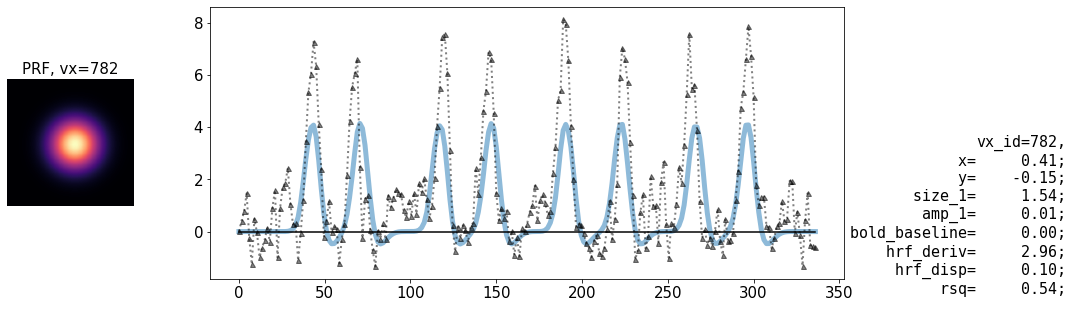

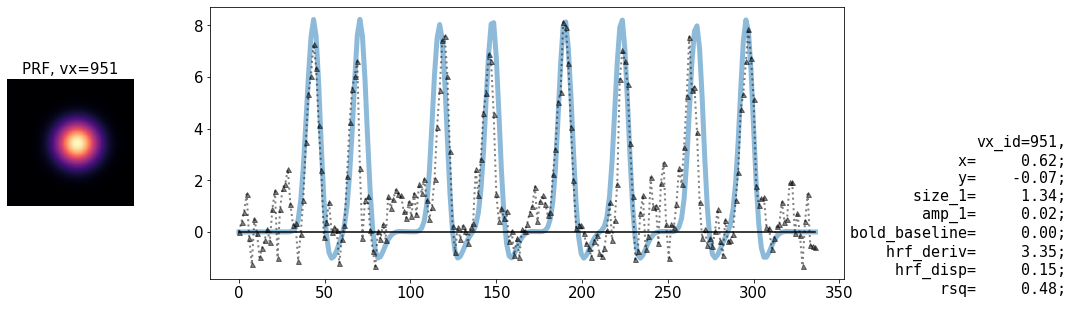

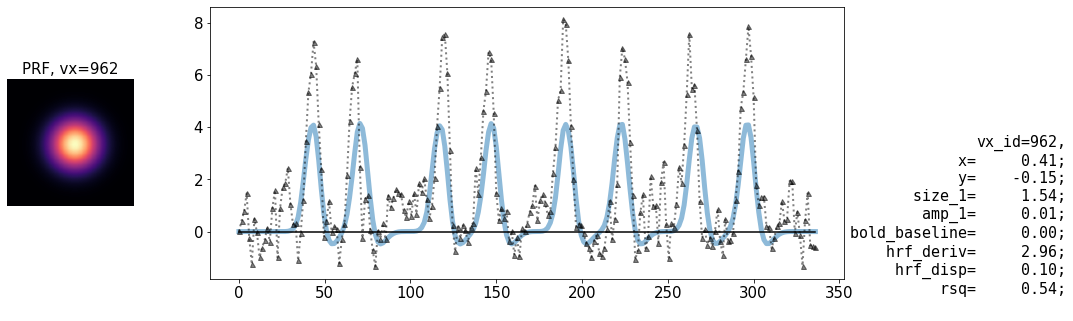

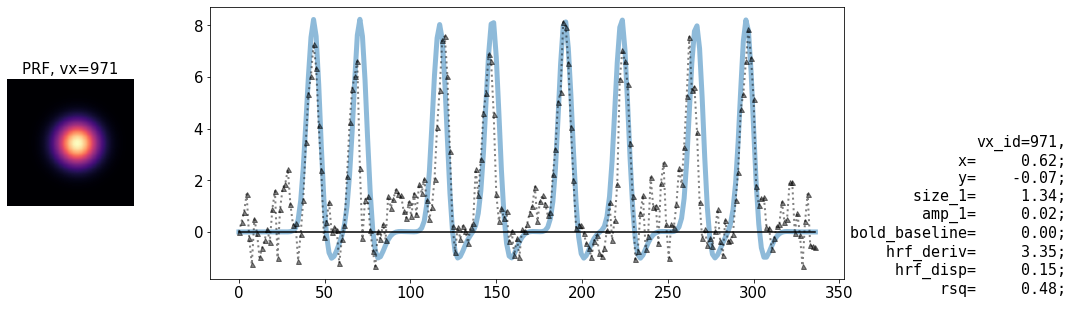

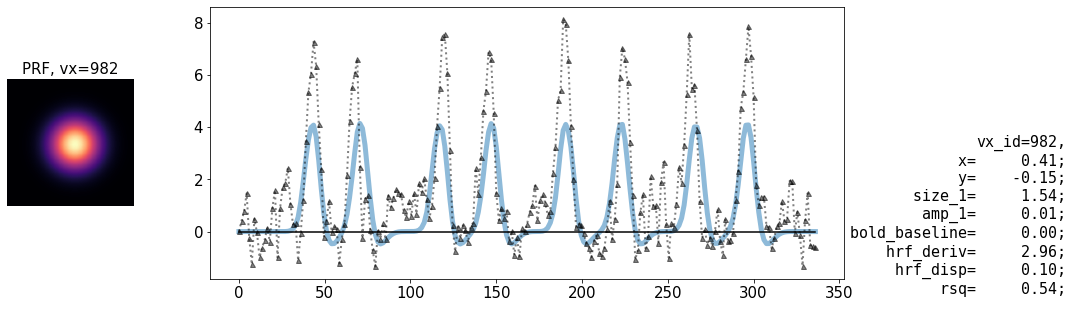

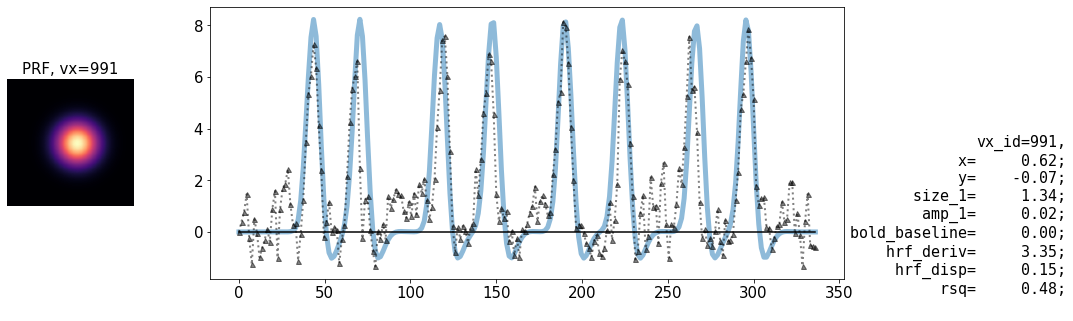

In [6]:
# Ok that was interesting. 
# Lets look at some time series! Ideally where parameters differ, so we can see this tradeoff type thing
good_fits = np.where(Gbprf.sampler[idx].pd_params['rsq'] > 0.3)[0]
plot_eg = 0
size_previous = -100
for i in good_fits:
    size_current = Gbprf.sampler[idx].pd_params['size_1'][i]
    if np.abs(size_current - size_previous) < 0.2:
        continue
    else:
        # Plot it if the size is different enough!!
        size_previous = size_current
        _ = Gbprf.sampler[idx].prf_ts_plot(i)
        plot_eg += 1
    if plot_eg > 5:
        break
        
    

# DN - same again but with the divisive normalisation model!

In [7]:
from prfpy_bayes.prf_bayes import BayesPRF
# Start by making the bprf objects
Nbprf = BayesPRF(
    prf_params=None, # We could put in our best guess here, but we will let the model figure it out...
    model = 'norm',
    prfpy_model=dn_model,
    real_ts=psc_runs,
    )
Nbounds = {
    'x': [-5, 5],
    'y': [-5, 5],
    'size_1': [0.1, 10],
    'amp_1': [0, 100],
    'size_2' : [0.1, 10],
    'amp_2' : [0, 100],
    'b_val' : [0, 100],
    'd_val' : [0, 100],
    'bold_baseline': [0, 0],
    'hrf_deriv' : [4.6, 4.6], # Not going to fit the HRF, we have enough to deal with...
    'hrf_disp' : [0, 0],
}

Nbprf.add_priors_from_bounds(Nbounds)
Nbprf.prep_info()
print(Nbprf.init_p_id)

prf_params.shape[-1]=12
include hrf = True
include rsq = True
{'x': 0, 'y': 1, 'size_1': 2, 'amp_1': 3, 'amp_2': 4, 'size_2': 5, 'b_val': 6, 'd_val': 7}


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:296: RuntimeWarning: invalid value encountered in divide
  self.params_dd['size_ratio'] = self.params_dd['size_2'] / self.params_dd['size_1']
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:297: RuntimeWarning: invalid value encountered in divide
  self.params_dd['amp_ratio'] = self.params_dd['amp_2'] / self.params_dd['amp_1']
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:299: RuntimeWarning: invalid value encountered in divide
  self.params_dd['bd_ratio'] = self.params_dd['b_val'] / self.params_dd['d_val']
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:301: RuntimeWarning: invalid value encountered in divide
  self.params_dd['sup_idx'] = (self.params_dd['amp_1'] * self.params_dd['size_1']**2) / (self.params_dd['amp_2']

In [9]:

Nbprf.run_mcmc_fit(
    # initial_guess=initial_guess,
    idx=idx, 
    n_walkers=30,
    n_steps=500, 
)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(11,)
11
x
y
size_1
amp_1
amp_2
size_2
b_val
d_val
Running in serial


/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/daghlian/.conda/envs/dag_mcmc

emcee: Exception while calling your likelihood function:
  params: [ 4.92653151e-05  1.30476781e-04  8.30198214e-05  1.42548813e-05
 -8.56109107e-05  2.25497278e-05  3.56064315e-05  1.47059295e-04]
  args: (array([ 4.73582000e-03,  4.04758483e-01,  7.71729052e-01,  1.46421933e+00,
       -2.41428167e-01, -1.25546718e+00,  4.85224217e-01, -2.95125470e-02,
       -9.83243823e-01, -6.20959759e-01, -3.11213672e-01,  1.27842471e-01,
       -3.81369203e-01,  9.04257953e-01,  1.58567357e+00, -9.92647648e-01,
        9.00521159e-01,  1.70337832e+00,  1.85752678e+00,  2.43104815e+00,
        1.07344639e+00,  2.76786476e-01,  3.27918530e-01, -1.10569060e+00,
       -6.61534891e-02,  1.22905016e+00,  3.47125745e+00,  5.33978510e+00,
        6.05485678e+00,  7.27212334e+00,  6.35323811e+00,  4.13702250e+00,
        2.41314697e+00, -2.14591861e-01,  4.01619732e-01,  1.17908359e+00,
       -5.69778355e-03,  2.05243543e-01,  8.74585137e-02, -1.21430624e+00,
       -2.65341610e-01,  2.82761753e-01,  2

KeyboardInterrupt: 

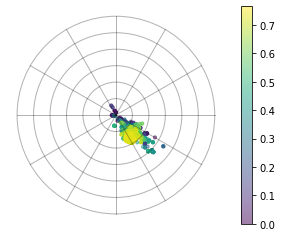

In [ ]:
Nbprf.sampler[idx].visual_field(
    dot_col='rsq', 
    th={'min-rsq':0},
    do_colbar=True,
    dot_vmin=0, 
    dot_size=10,
)

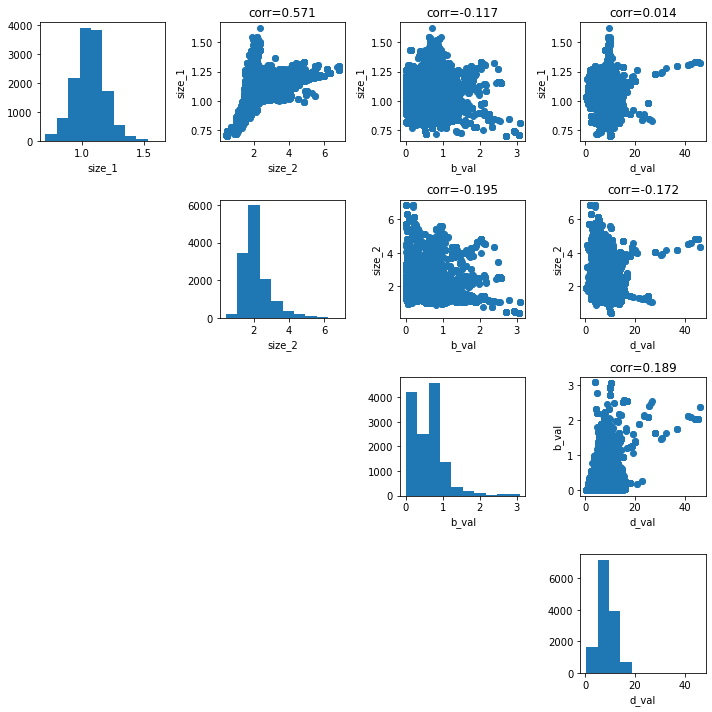

In [ ]:
# Multiple scatter for several parameters 
Nbprf.sampler[idx].multi_scatter(
    ['size_1', 'size_2','b_val', 'd_val'],
    # pc='rsq', 
    th={'min-rsq':0, 'min-step_id':burn_in},
    # do_id_line=True, 
)
plt.gcf().set_size_inches(10,10)